#Tumor Track

In [ ]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU is available. Using:", torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print("GPU is not available. Using CPU.")


GPU is available. Using: Tesla T4


Import Libraries

In [ ]:
# Import Necessary Modules
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
import os
import albumentations as A


## Data Processing

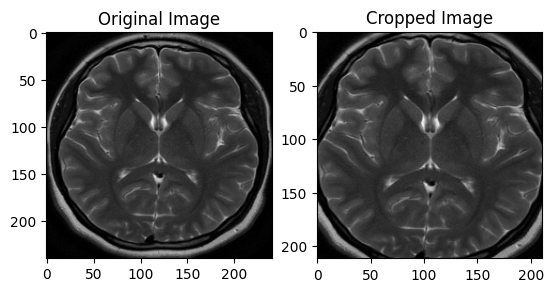

In [7]:
# Function to crop the brain contour from the MRI images
def crop_brain_contour(image, plot=False):
    """
    Crops the brain contour from the MRI image.
    Arguments:
        image: Input image.
        plot: Boolean, if True plots the original and cropped image.
    Returns:
        new_image: Cropped image containing the brain contour.
    """
    if image is None:
        raise ValueError("Image not found or unable to read the image file.")

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert image to grayscale
    gray = cv2.GaussianBlur(gray, (5, 5), 0)  # Blur the image to reduce noise

    # Threshold the image
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in the thresholded image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)  # Get the largest contour

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Crop the image using the extreme points
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')


        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
        plt.title('Cropped Image')

        plt.show()

    return new_image

# Example usage of the crop_brain_contour function
image_path = '/content/augmented_data/no/1 no.jpeg'
if os.path.exists(image_path):
    ex_img = cv2.imread(image_path)
    ex_new_img = crop_brain_contour(ex_img, True)
else:
    print(f"Image not found at path: {image_path}")

In [6]:
def data_summary(main_path):
    yes_path = 'augmented_data/' + 'yes/'
    no_path =  'augmented_data/' + 'no/'

    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))

    n = (n_pos + n_neg)

    pos_per = (n_pos*100)/n
    neg_per = (n_neg*100)/n

    print(f"Number of sample: {n}")
    print(f"{n_pos} Number of positive sample in percentage: {pos_per}%")
    print(f"{n_neg} Number of negative sample in percentage: {neg_per}%")

data_summary('augmented_data')

Number of sample: 1513
925 Number of positive sample in percentage: 61.136814276272304%
588 Number of negative sample in percentage: 38.863185723727696%


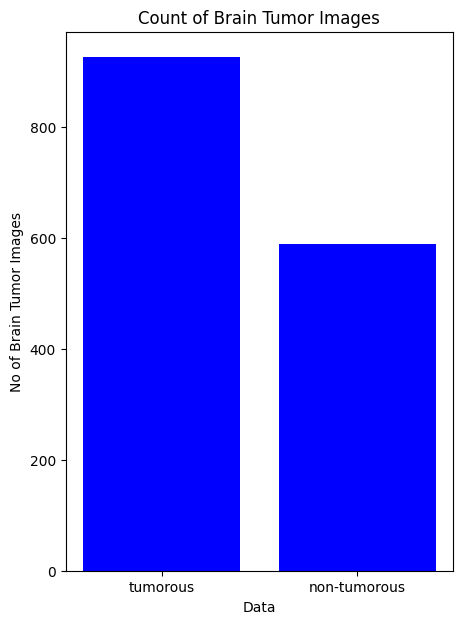

In [8]:
data = {'tumorous': len(os.listdir('augmented_data/' + 'yes/')), 'non-tumorous': len(os.listdir('augmented_data/' + 'no/'))}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="blue")

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

In [21]:
"""This has already been done on my local system

# Define the augmentation pipeline using Albumentations
def get_augmentation_pipeline():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Rotate(limit=20, p=0.5),
        A.HueSaturationValue(hue_shift_limit=7, sat_shift_limit=20, val_shift_limit=10, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=10, b_shift_limit=10, p=0.5),
    ])

# Function to load, augment and save data
def load_and_augment_data(dir_list, image_size, augmentations, save_dir, augment_times=5):
    Loads, augments, and preprocesses image data.
    Arguments:
        dir_list: List of directories containing the images.
        image_size: Tuple specifying the size to resize images to.
        augmentations: Albumentations augmentation pipeline.
        save_dir: Directory to save augmented images.
        augment_times: Number of times to augment each image.
    Returns:
        X: Array of preprocessed images.
        y: Array of labels corresponding to the images.
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        label = 1 if directory.endswith('yes') else 0
        save_subdir = 'yes' if label == 1 else 'no'
        save_path = os.path.join(save_dir, save_subdir)
        os.makedirs(save_path, exist_ok=True)

        for filename in listdir(directory):
            image_path = os.path.join(directory, filename)
            image = cv2.imread(image_path)
            if image is None:
                print(f"Unable to read image at path: {image_path}")
                continue

            image = crop_brain_contour(image, plot=False)  # Crop brain contour
            image = cv2.resize(image, (image_width, image_height))  # Resize image
            X.append(image)
            y.append([label])

            # Save original image
            save_image_path = os.path.join(save_path, filename)
            cv2.imwrite(save_image_path, image)

            # Augment the image multiple times and save
            for i in range(augment_times):
                augmented = augmentations(image=image)['image']
                X.append(augmented)
                y.append([label])

                augmented_filename = f"{os.path.splitext(filename)[0]}_aug_{i}.jpg"
                augmented_save_image_path = os.path.join(save_path, augmented_filename)
                cv2.imwrite(augmented_save_image_path, augmented)

    X = np.array(X)
    y = np.array(y)

    X, y = shuffle(X, y)  # Shuffle data

    print(f'Number of examples: {len(X)}')
    print(f'X shape: {X.shape}')
    print(f'y shape: {y.shape}')

    return X, y

# Load and augment data
data_path = 'data/'
data_yes = os.path.join(data_path, 'yes')
data_no = os.path.join(data_path, 'no')

save_path = 'augmented_data'
IMG_WIDTH, IMG_HEIGHT = (240, 240)
augmentation_pipeline = get_augmentation_pipeline()

X, y = load_and_augment_data([data_yes, data_no], (IMG_WIDTH, IMG_HEIGHT), augmentation_pipeline, save_path)
"""

'This has already been done on my local system\n\n# Define the augmentation pipeline using Albumentations\ndef get_augmentation_pipeline():\n    return A.Compose([\n        A.HorizontalFlip(p=0.5),\n        A.VerticalFlip(p=0.5),\n        A.RandomRotate90(p=0.5),\n        A.Rotate(limit=20, p=0.5),\n        A.HueSaturationValue(hue_shift_limit=7, sat_shift_limit=20, val_shift_limit=10, p=0.5),\n        A.RGBShift(r_shift_limit=15, g_shift_limit=10, b_shift_limit=10, p=0.5),\n    ])\n\n# Function to load, augment and save data\ndef load_and_augment_data(dir_list, image_size, augmentations, save_dir, augment_times=5):\n    Loads, augments, and preprocesses image data.\n    Arguments:\n        dir_list: List of directories containing the images.\n        image_size: Tuple specifying the size to resize images to.\n        augmentations: Albumentations augmentation pipeline.\n        save_dir: Directory to save augmented images.\n        augment_times: Number of times to augment each image.

In [11]:
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split

#Split the augmented data into training, testing and validation data
def data_split(source):
    train_dir = os.path.join(source, 'train')
    test_dir = os.path.join(source, 'test')
    val_dir = os.path.join(source, 'val')

    Path(train_dir).mkdir(parents=True, exist_ok=True)
    Path(test_dir).mkdir(parents=True, exist_ok=True)
    Path(val_dir).mkdir(parents=True, exist_ok=True)

    all_data = os.listdir(source)

    # Remove directories from the list of files
    all_data = [f for f in all_data if os.path.isfile(os.path.join(source, f))]

    # Split the file names into training and temp sets (70% training, 30% temp)
    train_files, temp_files = train_test_split(all_data, test_size=0.3, random_state=42)

    # Further split the temp set into validation and test sets (50% validation, 50% test of the temp set)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    # Function to move files
    def move_files(files, dest_dir):
        for file_name in files:
            shutil.move(os.path.join(source, file_name), os.path.join(dest_dir, file_name))

    move_files(train_files, train_dir)
    move_files(test_files, test_dir)
    move_files(val_files, val_dir)

data_split('augmented_data/yes/')
data_split('augmented_data/no/')


Yes - Train


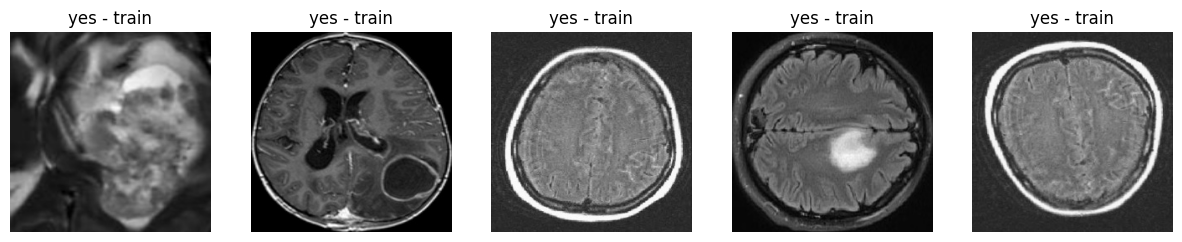

Yes - Validation


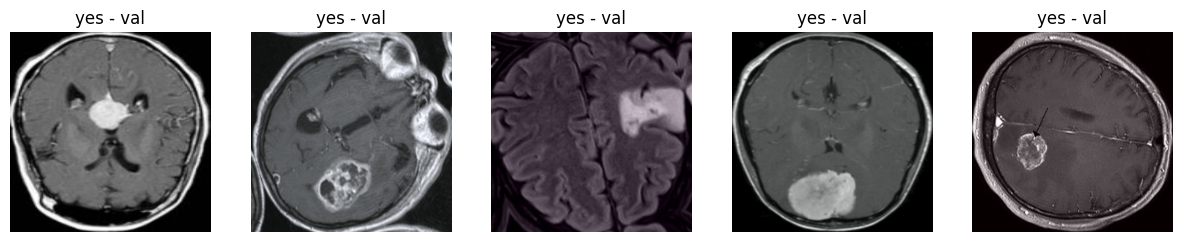

Yes - Test


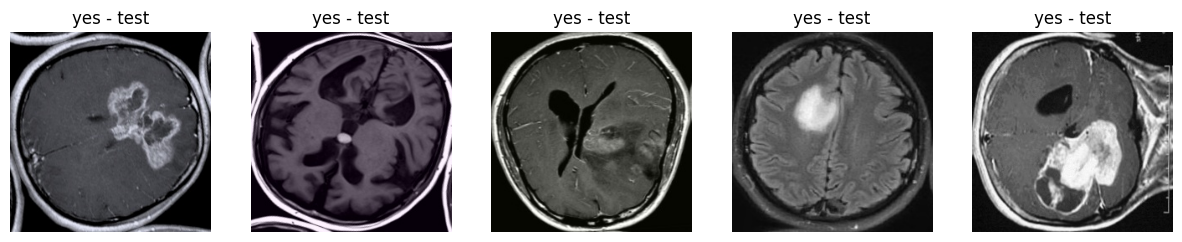

No - Train


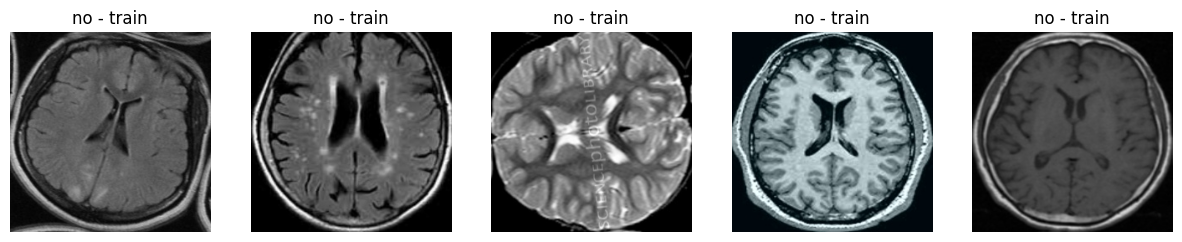

No - Validation


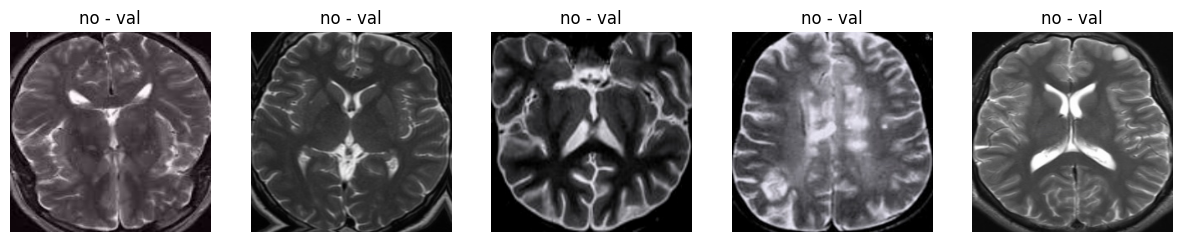

No - Test


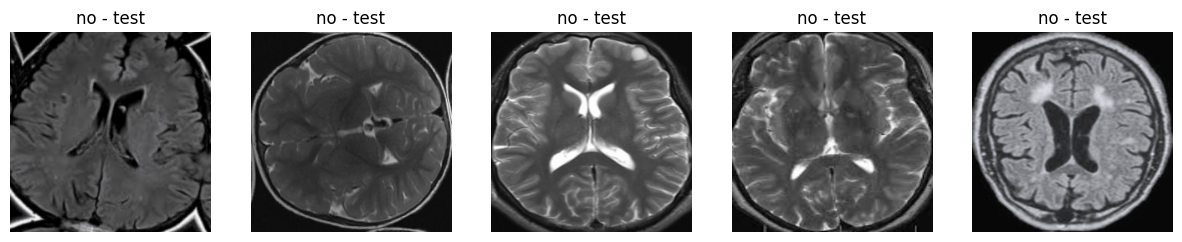

In [23]:
import random
import cv2
import os
import matplotlib.pyplot as plt

def plot_sample_images(base_dir, category, subset, num_images=5):
    """
    Plots sample images from the specified category and subset.

    Arguments:
    base_dir -- the base directory where the images are stored
    category -- the category folder name ("yes" or "no")
    subset -- the subset folder name ("train", "val", or "test")
    num_images -- number of images to display
    """
    folder_path = os.path.join(base_dir, category, subset)
    all_images = os.listdir(folder_path)

    # Randomly select images
    sample_images = random.sample(all_images, num_images)

    plt.figure(figsize=(15, 5))

    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f"{category} - {subset}")
        plt.axis('off')

    plt.show()

# Base directory where the images are stored
base_dir = '/content/augmented_data'

# Plot images from each subset for "yes" category
print("Yes - Train")
plot_sample_images(base_dir, 'yes', 'train', num_images=5)
print("Yes - Validation")
plot_sample_images(base_dir, 'yes', 'val', num_images=5)
print("Yes - Test")
plot_sample_images(base_dir, 'yes', 'test', num_images=5)

# Plot images from each subset for "no" category
print("No - Train")
plot_sample_images(base_dir, 'no', 'train', num_images=5)
print("No - Validation")
plot_sample_images(base_dir, 'no', 'val', num_images=5)
print("No - Test")
plot_sample_images(base_dir, 'no', 'test', num_images=5)


## Building Model

Model: "BrainTumorModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d_2 (ZeroPadd  (None, 246, 246, 3)       0         
 ing2D)                                                          
                                                                 
 conv0 (Conv2D)              (None, 240, 240, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 240, 240, 32)      128       
                                                                 
 activation_6 (Activation)   (None, 240, 240, 32)      0         
                                                                 
 max_pool (MaxPooling2D)     (None, 120, 120, 32)      0         
                                                   

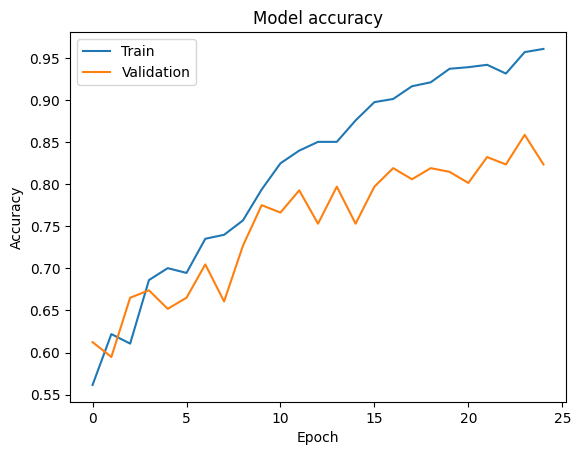

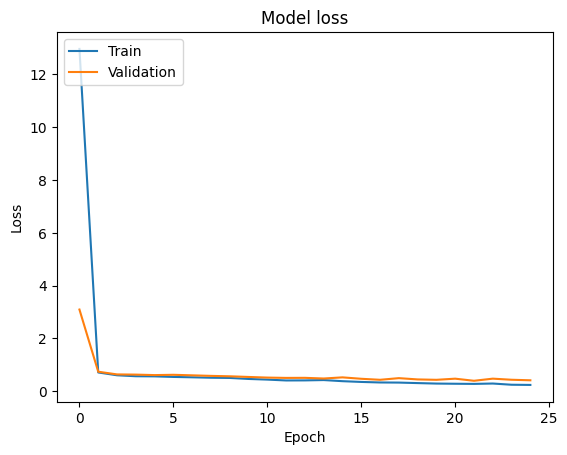

In [12]:
# Function to load images from a directory
def load_images_from_directory(base_dir, subset, image_size):
    images = []
    labels = []

    for label in ['yes', 'no']:
        label_dir = os.path.join(base_dir, label, subset)
        if not os.path.exists(label_dir):
            continue

        for filename in os.listdir(label_dir):
            file_path = os.path.join(label_dir, filename)
            image = cv2.imread(file_path)
            if image is not None:
                image = cv2.resize(image, image_size)
                images.append(image)
                labels.append(1 if label == 'yes' else 0)

    return np.array(images), np.array(labels)

# Load datasets
IMG_SIZE = (240, 240)
base_dir = '/content/augmented_data'

X_train, y_train = load_images_from_directory(base_dir, 'train', IMG_SIZE)
X_val, y_val = load_images_from_directory(base_dir, 'val', IMG_SIZE)
X_test, y_test = load_images_from_directory(base_dir, 'test', IMG_SIZE)

# Normalize pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Define the CNN model architecture
def build_model(input_shape):
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(32, (7, 7), strides=(1, 1), name='conv0')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # Stage 2
    X = Conv2D(64, (3, 3), strides=(1, 1), name='conv1')(X)
    X = BatchNormalization(axis=3, name='bn1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool1')(X)

    # Stage 3
    X = Conv2D(128, (3, 3), strides=(1, 1), name='conv2')(X)
    X = BatchNormalization(axis=3, name='bn2')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool2')(X)

    # Flatten the layers
    X = Flatten()(X)

    # Fully connected layers
    X = Dense(128, activation='relu', name='fc1')(X)
    X = Dense(1, activation='sigmoid', name='fc2')(X)

    model = Model(inputs=X_input, outputs=X, name='BrainTumorModel')

    return model

# Compile the model
model = build_model((IMG_SIZE[0], IMG_SIZE[1], 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Callbacks for saving the best model and logging
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
tensorboard = TensorBoard(log_dir="logs/{}".format(time.time()))

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, batch_size=32, callbacks=[checkpoint, tensorboard])

# Load the best model
best_model = load_model('best_model.keras')

# Evaluate the model on test data
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot training & validation accuracy and loss
def plot_history(history):
    # Accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_history(history)

## Evaluation of Results


The brain tumor detection model is a Convolutional Neural Network (CNN) designed to classify MRI images into tumorous and non-tumorous categories. It starts with an input layer that accepts images of shape 240x240x3, followed by a ZeroPadding2D layer to maintain spatial dimensions. The model consists of three convolutional stages. The first stage applies a 32-filter, 7x7 convolution, followed by batch normalization, a ReLU activation function, and a 2x2 max pooling layer to down-sample the spatial dimensions. The second stage uses a 64-filter, 3x3 convolution with batch normalization, ReLU activation, and another 2x2 max pooling layer. The third stage further increases complexity with a 128-filter, 3x3 convolution, again followed by batch normalization, ReLU activation, and 2x2 max pooling. After these convolutional stages, the feature maps are flattened into a 1D vector, which is passed through a fully connected (dense) layer with 128 neurons and a ReLU activation. Finally, the output layer uses a single neuron with a sigmoid activation function to produce a probability score for the binary classification task. The model is compiled using the Adam optimizer, binary cross-entropy loss function, and accuracy as the primary performance metric.

**Model Accuracy**:
The first graph illustrates the training and validation accuracy of my model over 25 epochs. The blue line represents the training accuracy, while the orange line represents the validation accuracy.

Initially, both training and validation accuracy increase rapidly, indicating that the model is learning from the data.
Around the 10th epoch, the validation accuracy starts to fluctuate, indicating that the model's performance on the validation set is becoming less consistent.
The training accuracy continues to improve steadily and reaches about 95% by the end of the training period.
However, the validation accuracy stabilizes around 80% with some fluctuations, suggesting that the model might be starting to overfit to the training data. Overfitting occurs when the model learns the training data too well, including the noise and outliers, which negatively affects its performance on new, unseen data.
\
**Model Loss**:
The second graph shows the training and validation loss over the same 25 epochs. The blue line represents the training loss, and the orange line represents the validation loss.

Both the training and validation loss drop significantly within the first few epochs, indicating that the model is effectively learning and reducing errors.
After the initial drop, the training loss continues to decrease gradually, approaching zero, which is expected as the model fits the training data more closely.
The validation loss, however, plateaus and shows minor fluctuations around a certain value, which is higher than the training loss.
The divergence between the training loss and validation loss over time is another indication of overfitting, as the model's error on the validation set does not decrease as much as on the training set.

8/8 [==============================] - 0s 49ms/step
Precision: 0.85
Recall: 0.91
F1 Score: 0.88
ROC-AUC Score: 0.91


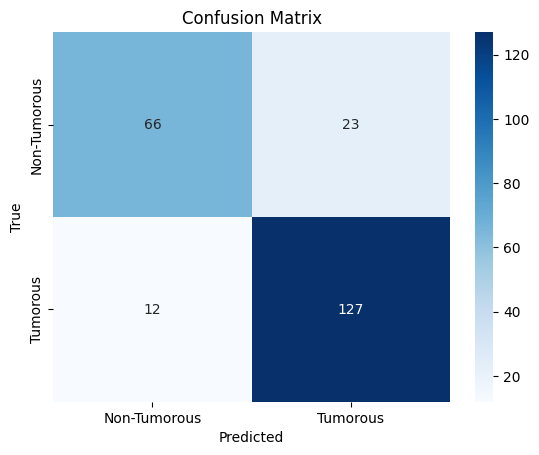

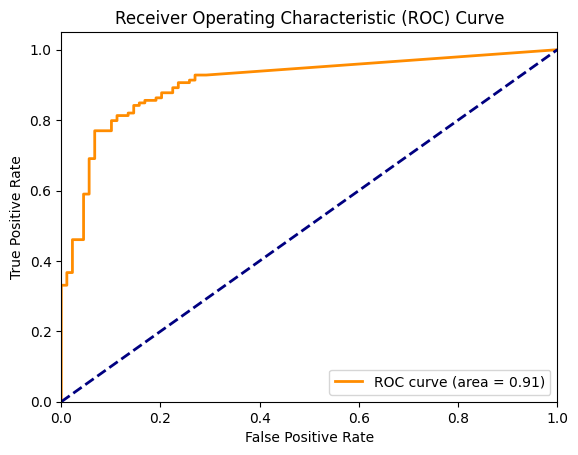

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import seaborn as sns

# Make predictions
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")
y_pred_proba = best_model.predict(X_test)

# Calculate metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Tumorous', 'Tumorous'], yticklabels=['Non-Tumorous', 'Tumorous'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Confusion Matrix: This shows the distribution of my model's predictions. Most predictions are correct, with 127 true positives and 66 true negatives.
ROC Curve: The ROC curve illustrates the trade-off between the true positive rate and false positive rate. The closer the curve is to the top-left corner, the better the model. My model's ROC curve, with an AUC of 0.91, indicates strong performance.

Overall, my model performs well, with high precision (0.85), recall (0.91), and an F1 score of 0.88. The ROC-AUC score of 0.91 further validates its ability to effectively distinguish between tumorous and non-tumorous images. This suggests that my model is well-suited for brain tumor detection tasks.